In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv
import os
data_name = 'Pancreas_with_cc'

Global seed set to 0


You need to change this to suitable directories on your system:

In [2]:
# Data name, where to download data and where to save results
data_path = '/home/jupyter/data/benchmarking_datasets/Pancreas_with_cc/'
results_path = '/home/jupyter/data/cell2fate_paper_results/'

In [3]:
# # Downloading data into specified directory:
# os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

Load the data and preprocess the data, because we are using a model version that expects preprocessed data:

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


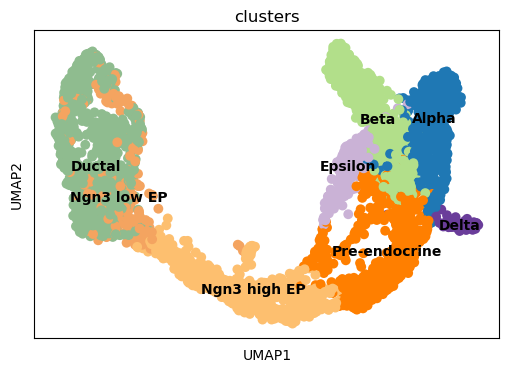

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

We initialize the model, which includes automatically setting a maximal number of modules, based on the number of Louvain clusters (times 1.15) in the data.

In [6]:
c2f.Cell2fate_DynamicalModel_PreprocessedCounts.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

In [7]:
n_modules = 30 #c2f.utils.get_max_modules(adata)

In [8]:
mod = c2f.Cell2fate_DynamicalModel_PreprocessedCounts(adata, n_modules = n_modules)

Training the model:

In [9]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [23:44<00:00,  2.85s/it, v_num=1, elbo_train=7.37e+6]


Exporting relevant model parameters to the anndata object:

In [10]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 3696
Sampling global variables, sample: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

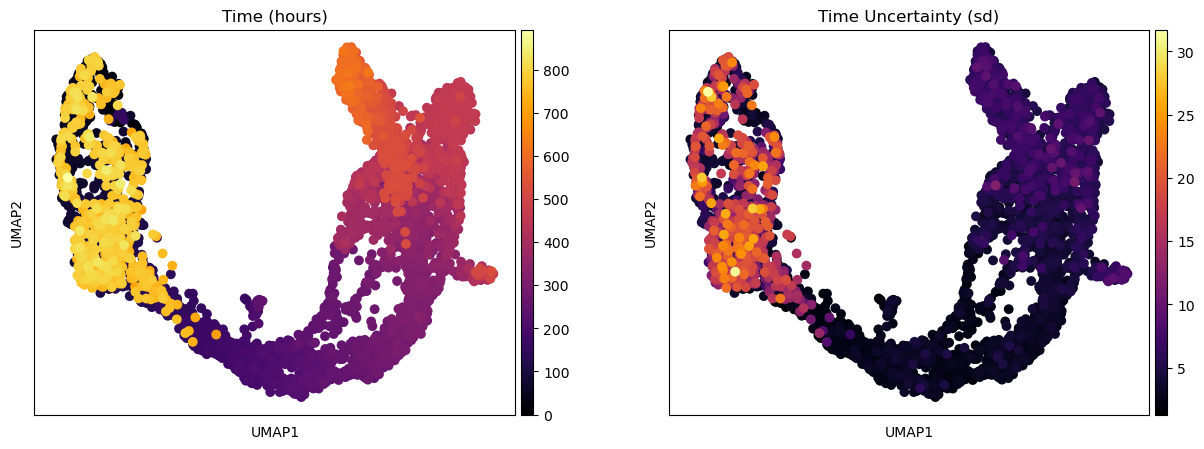

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time_nModules1' + str(n_modules) + '.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

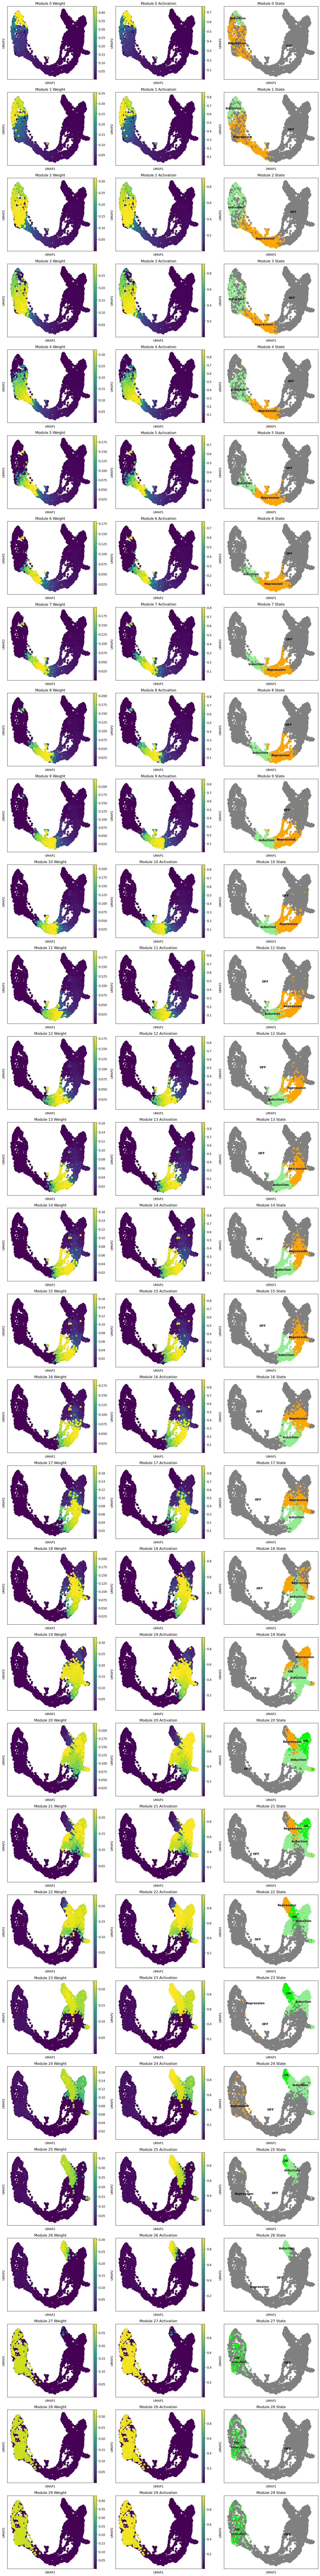

In [12]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot1.pdf')

This is an alternative way to visualize module activation over time:

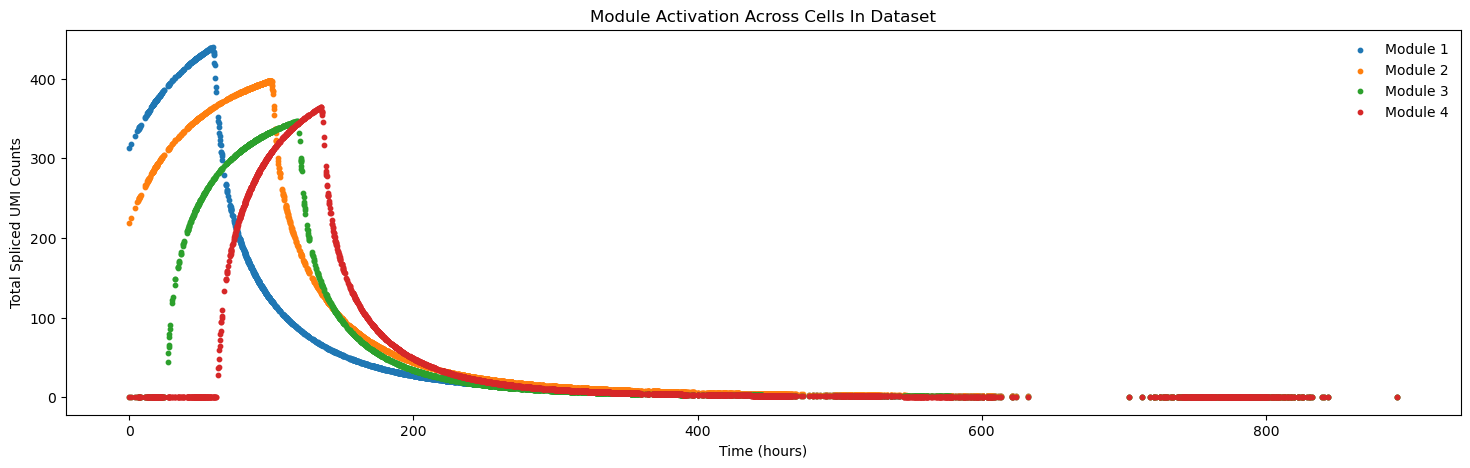

In [13]:
mod.compare_module_activation(adata, chosen_modules = [1,2,3,4,],
                         save = results_path + data_name + 'module_activation_comparison1.pdf')

For large datasets (> 10000 cells) we recommend the scalable scVelo workflow for computing and plotting the velocity graph, which is used in this method:

Computing total RNAvelocity ...


  0%|          | 0/3696 [00:00<?, ?cells/s]

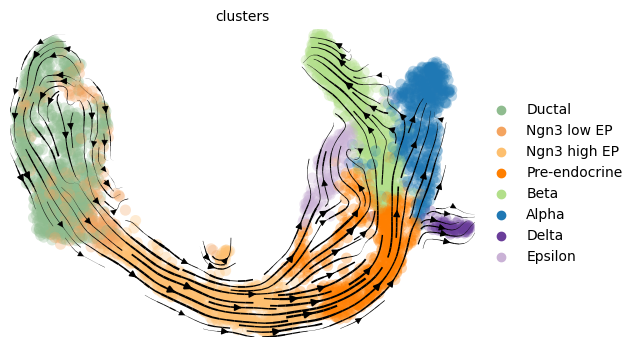

In [14]:
mod.compute_and_plot_total_velocity_scvelo(adata, save = results_path + data_name + 'total_velocity_plots1.png', delete = False)

For smaller datasets (< 10000 cells) our own method that takes into account posterior uncertainty, when computing the velocity graph can be used:

Computing total RNAvelocity ...


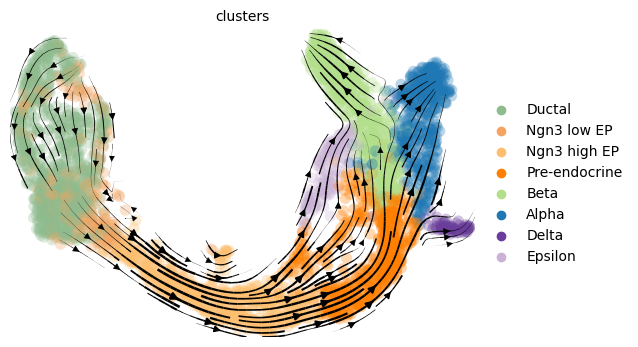

In [15]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots1.png', delete = False)

The delete=False command saves the RNA velocity for each gene in both cases in an adata.layers slot.

For a visualization that is more similar to the scvelo plots:

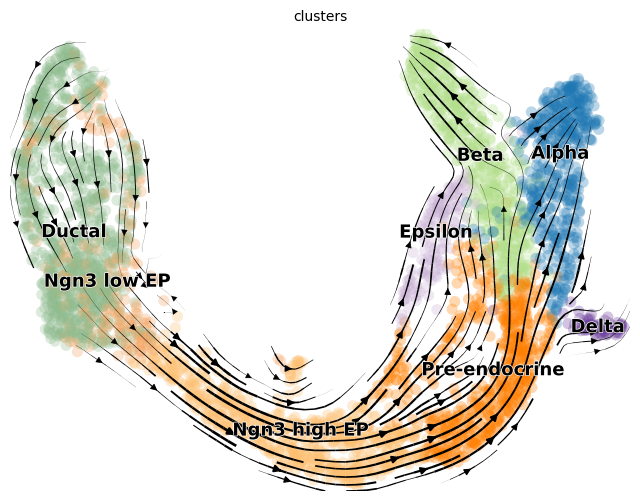

In [16]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots1.png')

In [17]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', '_indices', '_scvi_batch', 'Time (hours)', 'Time Uncertainty (sd)', 'Module 0 Weight', 'Module 0 Activation', 'Module 0 State', 'Module 1 Weight', 'Module 1 Activation', 'Module 1 State', 'Module 2 Weight', 'Module 2 Activation', 'Module 2 State', 'Module 3 Weight', 'Module 3 Activation', 'Module 3 State', 'Module 4 Weight', 'Module 4 Activation', 'Module 4 State', 'Module 5 Weight', 'Module 5 Activation', 'Module 5 State', 'Module 6 Weight', 'Module 6 Activation', 'Module 6 State', 'Module 7 Weight', 'Module 7 Activation', 'Module 7 State', 'Module 8 Weight', 'Module 8 Activation', 'Module 8 State', 'Module 9 Weight', 'Module 9 Activation', 'Module 9 State', 'Module 10 Weight', 'Module 10 Activation', 'Module 10 State', 'Module 11 Weight', 'Module 11 Activation', 'Module 11 State', 'Module 12 Weig

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

In [19]:
# mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot1.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [20]:
mod.samples['post_sample_means'].keys()

dict_keys(['splicing_alpha', 'splicing_mean', 'beta_g', 'degredation_alpha', 'degredation_mean', 'gamma_g', 'factor_level_g', 'g_fg', 'A_mgON', 'lam_mu', 'lam_sd', 'lam_m_mu', 'lam_mi', 'Tmax', 't_c_loc', 't_c_scale', 't_c', 'T_c', 't_delta', 'T_mON', 't_mOFF', 'T_mOFF', 'mu_expression', 'sigma_g_hyp', 'sigma_g_inv', 'mu', 'data_target'])

In [21]:
print('CV_g mean:', np.mean(mod.samples['post_sample_means']['mu'])/np.mean(1/mod.samples['post_sample_means']['sigma_g_inv']**2))
print('CV_gu mean:', np.mean(mod.samples['post_sample_means']['mu'][...,0])/np.mean(1/mod.samples['post_sample_means']['sigma_g_inv'][...,0]**2))
print('CV_gs mean:', np.mean(mod.samples['post_sample_means']['mu'][...,1])/np.mean(1/mod.samples['post_sample_means']['sigma_g_inv'][...,1]**2))
print('sigma_g mean:', 1/np.mean(mod.samples['post_sample_means']['sigma_g_inv'])**2)
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

CV_g mean: 0.5595667
CV_gu mean: 0.5353209
CV_gs mean: 0.5687902
sigma_g mean: 0.32679831714080465
A_mgON mean: 0.039978363
gamma_g mean: 0.75089854
beta_g mean: 1.4617634
lam_mi, all modules: 
 
 [[[2.09 0.69]]

 [[2.07 1.03]]

 [[4.27 1.68]]

 [[1.67 1.04]]

 [[2.4  1.44]]

 [[2.29 1.75]]

 [[2.34 1.28]]

 [[2.86 1.43]]

 [[2.2  2.42]]

 [[3.11 2.73]]

 [[0.47 0.44]]

 [[3.79 4.2 ]]

 [[1.58 1.47]]

 [[4.19 4.4 ]]

 [[1.67 0.8 ]]

 [[1.35 0.58]]

 [[0.82 0.51]]

 [[2.93 1.6 ]]

 [[4.13 2.65]]

 [[2.4  1.43]]

 [[1.62 0.7 ]]

 [[2.88 1.93]]

 [[4.93 2.3 ]]

 [[1.52 1.16]]

 [[1.68 1.29]]

 [[3.09 1.47]]

 [[0.73 0.82]]

 [[2.43 1.69]]

 [[2.62 2.28]]

 [[1.56 1.6 ]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [22]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table1.csv')

In [23]:
tab

Module Number                                       Genes Ranked  \
0               0  Ccnb1, Cdc25c, Cdc20, Birc5, Kif2c, Cks1b, Aur...   
1               1  Tk1, 2810417H13Rik, Gins2, Asf1b, Fbxo5, Mcm3,...   
2               2  Pdzk1ip1, Ankrd1, Acot1, Gja1, Rrm2, Ugt2b34, ...   
3               3  Cdt1, Rest, Hes1, Osgin1, Mcm6, Hells, Fgfr2, ...   
4               4  Cym, Vtcn1, Gas6, Cxcl12, Bcl2l14, Muc1, Pah, ...   
5               5  Tmem171, Dnah11, Grin3a, Serpina6, Aldh1b1, Dl...   
6               6  Dll1, Nptx2, Bcl2, Cdh11, Grin3a, Neurog3, Ras...   
7               7  Nptx2, Eda, Gadd45a, Megf11, Neurog3, Bcl2, Sp...   
8               8  Emid1, Cyp7b1, Pde9a, Slc39a2, Gadd45a, Tspear...   
9               9  Upk3bl, Olfm1, Glod5, Tspear, Notum, Tmsb4x, K...   
10             10  Btbd11, Scube1, Adamts18, Epb42, Gabbr2, Miat,...   
11             11  Srrm4, Sema3g, Adamts18, Dpysl5, Zfp423, Hpca,...   
12             12  Grik2, Tmem200a, Epb42, Gm13373, Scube1, Slc16...   
13             13  Slc8a1, St8sia2, Ebf1, Igfbp2, Kcnh8, Ctnna3, ...   
14             14  Fev, Clstn2, Dll3, Inppl1, Ffar2, Nod1, Lhx1os...   
15             15  Fev, Clstn2, Lrrtm3, Mreg, Stxbp5l, Sulf1, Acs...   
16             16  Ncam2, Fev, Sulf1, Asic2, BC023829, Diras2, St...   
17             17  Plac8, Zfp804a, Gm2694, Gm13373, Hs6st3, Slc25...   
18             18  Mnx1, Serpinb1a, Hdgfrp3, Col26a1, Samd5, Sdk1...   
19             19  Ppp1r14c, Usp18, Gm2115, Mreg, Cdh4, Hap1, Tsh...   
20             20  Rgs9, Cntnap5b, Lmo3, Serp2, 1500009L16Rik, Ad...   
21             21  Nap1l5, Irx2, Sorcs1, Peg10, Zcchc16, Gria2, N...   
22             22  Rtn1, Gast, Sst, Pcdh15, Ppy, Dpysl3, Stmn3, G...   
23             23  Skap1, Nrxn1, Pcsk2os1, Tnr, Syt9, Ripply3, Sy...   
24             24  Slc30a8, Slc7a2, Cntn1, Prune2, Myt1l, Pcsk2, ...   
25             25  Gip, Mapt, Cytip, Acvr1c, Cdh23, Frzb, Muc4, N...   
26             26  Ins2, Ins1, Arhgap36, Cntfr, Bace2, P2ry1, Npy...   
27             27  Mt2, Slc2a2, Galk1, Mmp14, Spp1, Serpina6, Nrt...   
28             28  Gas6, Smoc2, Sat1, Bst2, Cyr61, Gja1, Hes1, Sm...   
29             29  H2afz, Cnn2, Gm37350, Ankrd1, Spon1, Adamts16,...   

                                           TFs Ranked  \
0   Eno1, Fos, Ehf, Zfp637, Rest, Zfp36l1, Sox9, H...   
1   Dnmt1, Eno1, Nr4a1, Ezh2, Fos, E2f1, Rbpjl, Te...   
2   Klf6, Hhex, Relb, Nr1h4, Sox9, Atf3, Zfp637, I...   
3   Rest, Hes1, Ehf, Elf5, Nfib, Sox5, Zfp36l1, So...   
4   Zfp36l1, Ehf, Creb3l1, Neurog3, Ovol2, Mxd4, E...   
5   Zbtb16, Nfix, Bcl11b, Zfp467, Foxn3, Rfx3, Tea...   
6   Neurog3, Nfix, Klf13, Smarcd2, Rcor2, Foxa3, E...   
7   Neurog3, Smarcd2, Nfix, Tcf20, Tead2, Bcl11b, ...   
8   Nfix, E2f1, Smarcd2, Tcf20, Zfp423, Setbp1, Mx...   
9   Smarcd2, E2f1, Neurog3, Zfp423, Foxa3, Zbtb16,...   
10  Zfp423, E2f1, Lmx1b, Rcor2, Neurog3, Zfpm1, Fo...   
11  Zfp423, Lmx1b, Kcnip3, Rcor2, Zeb1, Mynn, D630...   
12  Myt1, Mxd1, Mxi1, Ikzf5, Setbp1, Kdm5a, Runx1t...   
13  Ebf1, Satb1, Bach2, Arx, Nfatc2, Peg3, Zfpm1, ...   
14  Ebf1, Runx1t1, Meis3, Skil, Zfhx2, Pcgf6, Lmx1...   
15  Ebf1, Zfp423, Kcnip3, Mxd1, Runx1t1, Zbtb16, H...   
16  Neurod1, Myt1, Rfx2, Runx1t1, Zbtb10, Bach2, F...   
17  Zfp804a, Vdr, Zfp174, Etv5, Fos, Nkx6-1, Smarc...   
18  Mnx1, Pdx1, Vdr, Nr4a2, Zbtb7c, Purg, Dach1, N...   
19  Tshz3, Zfp174, St18, Arx, Isl1, Id2, Zc3h6, Xb...   
20  Ddit3, Tshz1, Tshz3, Zfp516, Zeb1, Foxo1, Plag...   
21  Irx2, Smarca1, Arx, Etv1, Aff2, Ncoa7, Zim1, Z...   
22  Esrrg, Ikzf4, Rfx2, Tshz3, Meis2, Smarca1, Isl...   
23  Zc3h6, Zfhx2, Satb1, Hnf4a, Zeb1, Rora, Npas3,...   
24  Myt1l, Zbtb7c, Nfatc2, Nr1h4, Zfp516, Meis2, A...   
25  Mnx1, Pdx1, Mlxipl, Tshz1, Etv5, Rora, Foxo1, ...   
26  Satb1, Ddit3, Mxd1, Smarca2, Rora, Srebf2, Ovo...   
27  Sox9, Mxd4, Eno1, Zfp637, Rcor3, Stat3, Dnmt3a...   
28  Hes1, Sox9, Hhex, Zfp637, Rest, Id2, Zfp36l1, ...   
29  Ehf, Elf5, Nfib, Rest, Zfp36l1, Sox5, Tcf7l2, ...   

   

In [24]:
all_results[0]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
20  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
23  GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   
32  GO_Biological_Process_2021   
33  GO_Biological_Process_2021   
34  GO_Biological_Process_2021   
35  GO_Biological_Process_2021   
36  GO_Biological_Process_2021   
37  GO_Biological_Process_2021   
38  GO_Biological_Process_2021   
39  GO_Biological_Process_2021   
40  GO_Biological_Process_2021   
41  GO_Biological_Process_2021   
42  GO_Biological_Process_2021   
43  GO_Biological_Process_2021   
44  GO_Biological_Process_2021   
45  GO_Biological_Process_2021   
46  GO_Biological_Process_2021   
47  GO_Biological_Process_2021   
48  GO_Biological_Process_2021   
49  GO_Biological_Process_2021   
50  GO_Biological_Process_2021   
51  GO_Biological_Process_2021   
52  GO_Biological_Process_2021   
53  GO_Biological_Process_2021   
54  GO_Biological_Process_2021   
55  GO_Biological_Process_2021   
56  GO_Biological_Process_2021   
57  GO_Biological_Process_2021   
58  GO_Biological_Process_2021   

                                                 Term Overlap       P-value  \
0           mitotic spindle organization (GO:0007052)  14/157  1.343665e-21   
1   microtubule cytoskeleton organization involved...  11/128  8.171706e-17   
2   mitotic sister chromatid segregation (GO:0000070)   9/102  5.668647e-14   
3    mitotic metaphase plate congression (GO:0007080)    6/51  2.131092e-10   
4   regulation of mitotic cell cycle phase transit...   8/188  5.960913e-10   
5               mitotic spindle assembly (GO:0090307)    5/44  9.238328e-09   
6     cytoskeleton-dependent cytokinesis (GO:0061640)    5/72  1.151962e-07   
7   regulation of G2/M transition of mitotic cell ...   6/149  1.449731e-07   
8             mitotic spindle elongation (GO:0000022)     3/8  2.278745e-07   
9       mitotic spindle midzone assembly (GO:0051256)     3/8  2.278745e-07   
10  anaphase-promoting complex-dependent catabolic...    5/84  2.506417e-07   
11             regulation of cytokinesis (GO:0032465)    5/84  2.506417e-07   
12      regulation of mitotic cell cycle (GO:0007346)   6/178  4.143378e-07   
13  positive regulation of cell cycle process (GO:...   5/101  6.304340e-07   
14      regulation of cell cycle process (GO:0010564)   5/106  8.018900e-07   
15                   mitotic cytokinesis (GO:0000281)    4/49  1.234570e-06   
16  regulation of mitotic nuclear division (GO:000...    4/57  2.280413e-06   
17  spindle assembly checkpoint signaling (GO:0071...    3/21  5.333638e-06   
18  mitotic spindle assembly checkpoint signaling ...    3/21  5.333638e-06   
19  mitotic spindle checkpoint signaling (GO:0071174)    3/21  5.333638e-06   
20  negative regulation of mitotic metaphase/anaph...    3/22  6.168857e-06   
21              mitotic nuclear division (GO:0140014)    4/74  6.512950e-06   
22           regulation of cell division (GO:0051302)    4/76  7.245268e-06   
23              regulation of cell cycle (GO:0051726)   6/296  7.903635e-06   
24  re

To plot the expression and RNA velocity of individual module marker genes:

<AxesSubplot:title={'center':'Npy velocity'}, xlabel='UMAP1', ylabel='UMAP2'>

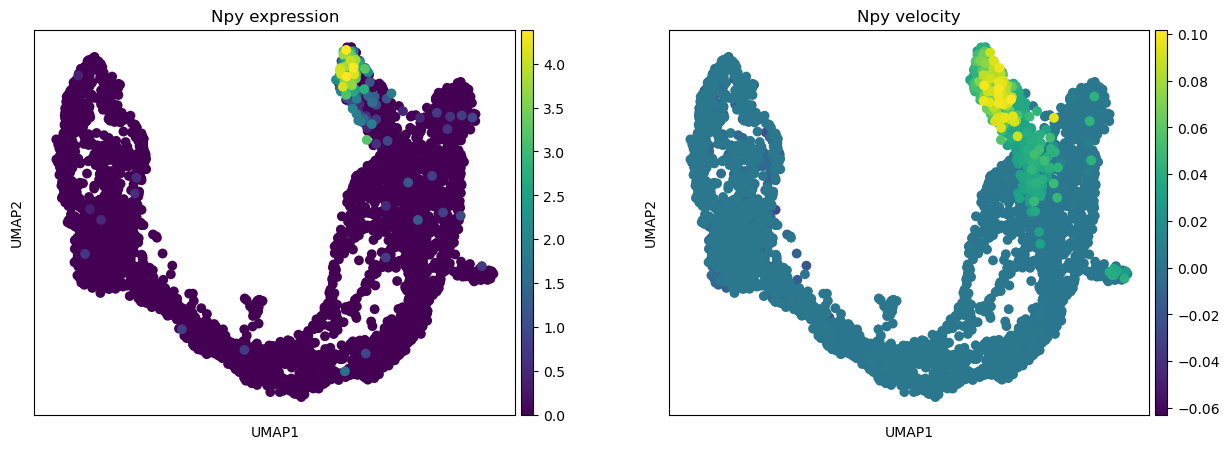

In [25]:
gene = 'Npy'
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           title = gene + ' expression', ax = ax[0])
sc.pl.umap(adata, color = [gene], s = 200, legend_loc='on data', show = False,
           layer = 'velocity', title = gene + ' velocity', ax = ax[1])